In [78]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model

import tensorflow.keras.backend as K
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [70]:
batch_size = 100
original_dim = 28 * 28
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [34]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [35]:
x = Input(shape=(original_dim, ), name='input')
h = Dense(intermediate_dim, activation='relu', name='encoding')(x)
z_mean = Dense(latent_dim, name='mean')(h)
z_log_var = Dense(latent_dim, name='log-variance')(h)
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')

In [36]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

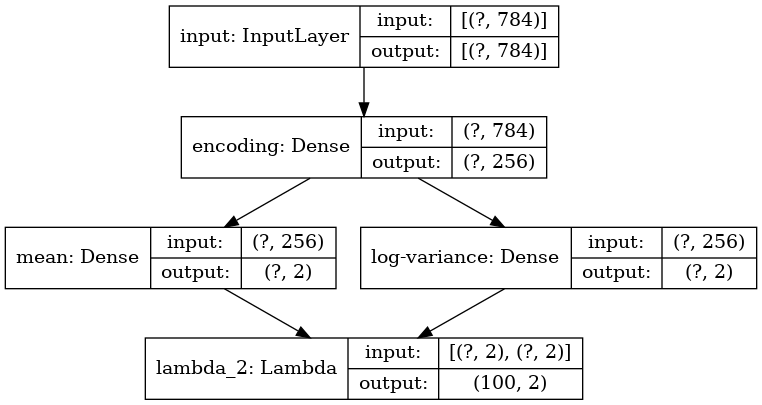

In [37]:
keras.utils.plot_model(encoder, 'encoder.png', show_shapes=True)

In [38]:
input_decoder = Input(shape=(latent_dim, ), name='decoder_input')
decoder_h = Dense(intermediate_dim, activation='relu', name='decoder_h')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name='flat_decoded')(decoder_h)
decoder = Model(input_decoder, x_decoded, name='decoder')

In [39]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


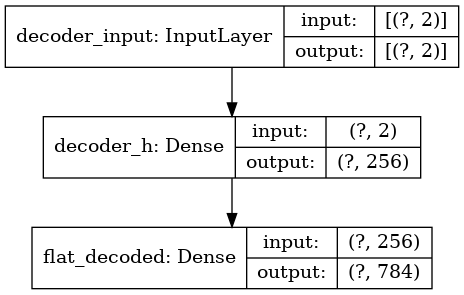

In [40]:
keras.utils.plot_model(decoder, 'decoder.png', show_shapes=True)

In [41]:
vae = Model(x, decoder(encoder(x)[2]))
vae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (1 201988    
_________________________________________________________________
decoder (Model)              multiple                  202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


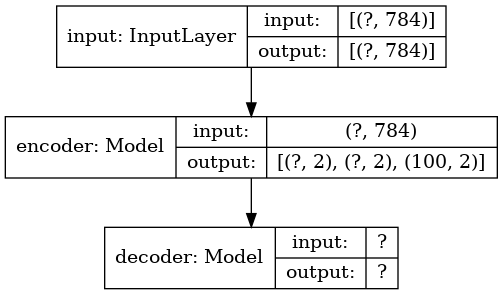

In [42]:
keras.utils.plot_model(vae, 'vae.png', show_shapes=True)

In [71]:
def vae_loss(x, x_decoded_mean, z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * BinaryCrossentropy()(x, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [72]:
vae.compile(optimizer='rmsprop',
            loss=vae_loss,
            experimental_run_tf_function=False)

In [73]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [74]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 19us/sample - loss: 154.6967
Epoch 2/50
60000/60000 [==============================] - 1s 18us/sample - loss: 154.2881
Epoch 3/50
60000/60000 [==============================] - 1s 18us/sample - loss: 153.9601
Epoch 4/50
60000/60000 [==============================] - 1s 21us/sample - loss: 153.6973
Epoch 5/50
60000/60000 [==============================] - 1s 22us/sample - loss: 153.4107
Epoch 6/50
60000/60000 [==============================] - 2s 33us/sample - loss: 153.1485
Epoch 7/50
60000/60000 [==============================] - 1s 18us/sample - loss: 152.9213
Epoch 8/50
60000/60000 [==============================] - 1s 18us/sample - loss: 152.7136
Epoch 9/50
60000/60000 [==============================] - 1s 18us/sample - loss: 152.4660
Epoch 10/50
60000/60000 [==============================] - 1s 18us/sample - loss: 152.2869
Epoch 11/50
60000/60000 [==============================] - 1s 18us/sample - 

In [75]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]

In [76]:
x_test_encoded.shape

(10000, 2)

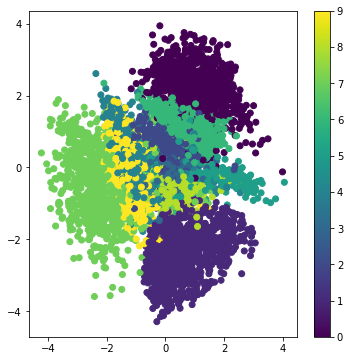

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

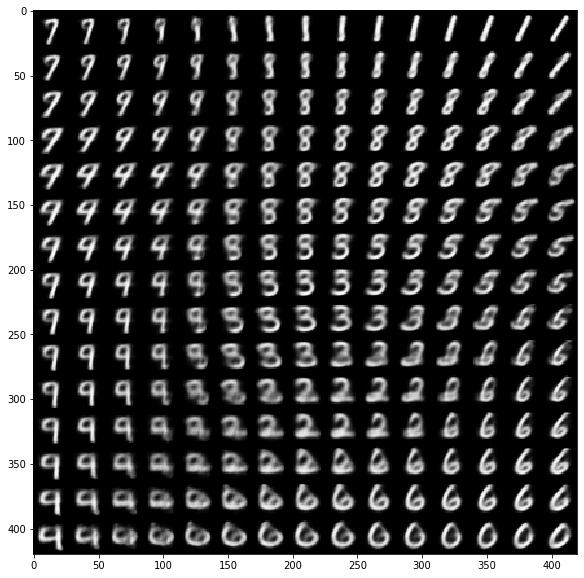

In [83]:
from scipy.stats import norm

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()